Загрузка самого датасета с Kaggle

In [ ]:
from google.colab import userdata
import os

#os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')
#os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')

In [ ]:
#!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification

# https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview

In [ ]:
#!unzip "jigsaw-unintended-bias-in-toxicity-classification.zip" -d "data"

In [ ]:
# BASE
import pandas as pd
import numpy as np
import datetime
import re
import string
import time
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# NLP
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import TweetTokenizer
from nltk.util import ngrams

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('universal_tagset')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [ ]:
df = pd.read_csv('train 2.csv', parse_dates=['created_date'], date_format='ISO8601').rename(columns={'target': 'toxicity'})

In [ ]:
df.head()

,id,toxicity,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006.0,rejected,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006.0,rejected,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006.0,rejected,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006.0,rejected,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006.0,rejected,0.0,0.0,0.0,1.0,0.0,0.0,4.0,47.0


Типы строк(признаков) в нашем датасете

In [ ]:
df.info(show_counts=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38442 entries, 0 to 38441
Data columns (total 45 columns):
 #   Column                               Non-Null Count  Dtype              
---  ------                               --------------  -----              
 0   id                                   38442 non-null  int64              
 1   toxicity                             38442 non-null  float64            
 2   comment_text                         38442 non-null  object             
 3   severe_toxicity                      38442 non-null  float64            
 4   obscene                              38442 non-null  float64            
 5   identity_attack                      38442 non-null  float64            
 6   insult                               38442 non-null  float64            
 7   threat                               38441 non-null  float64            
 8   asian                                7585 non-null   float64            
 9   atheist                     

In [ ]:
df['created_date']

,created_date
0,2015-09-29 10:50:41.987077+00:00
1,2015-09-29 10:50:42.870083+00:00
2,2015-09-29 10:50:45.222647+00:00
3,2015-09-29 10:50:47.601894+00:00
4,2015-09-29 10:50:48.488476+00:00
...,...
38437,2016-04-19 21:14:00.421506+00:00
38438,2016-04-19 21:15:19.806210+00:00
38439,2016-04-19 21:14:51.094200+00:00
38440,2016-04-19 21:14:14.673114+00:00


# Основные признаки:

*   comment_text - комментарий
*   toxicity - уровень токсичности комментария (комментарий считается токсичным при значениях >= 0.5)
*   toxic - бинарная переменная, которая указывает на токсичность комментария

# Дополнительные признаки отражающие уровни принадлежности к подтипам токсичных комментариев

*   severe_toxicity - высокая токсичность
*   obscene - нецензурность/непристойность
*   threat - угроза
*   insult - оскорбление
*   identity_attack - нападение на личность
*   sexual_explicit - откровенно сексуальный

# Дополнительные признаки отражающие упомянутые личностные атрибуты в комментарии:

*   male
*   female
*   transgender
*   other_gender
*   heterosexual
*   homosexual_gay_or_lesbian
*   bisexual
*   other_sexual_orientation
*   christian
*   jewish
*   muslim
*   hindu
*   buddhist
*   atheist
*   other_religion
*   black
*   white
*   asian
*   latino
*   other_race_or_ethnicity
*   physical_disability
*   intellectual_or_learning_disability
*   psychiatric_or_mental_illness
*   other_disability

### Вывод категориальных признаков


In [ ]:
df.describe(include='object')

,comment_text,rating
count,38442,38441
unique,37876,2
top,Start working at home with Google! It’s by-far...,approved
freq,24,36830


Количество значений N/A

In [ ]:
df.isna().sum()

,0
id,0
toxicity,0
comment_text,0
severe_toxicity,0
obscene,0
identity_attack,0
insult,0
threat,1
asian,30857
atheist,30857


Убираем дублирующиеся комментарии

In [ ]:
display("Кол-во комментариев до дедупликации комментариев")
df['comment_text'].duplicated().sum()

'Кол-во комментариев до дедупликации комментариев'

566

In [ ]:
df = df.dropna(subset='comment_text').sort_values(by='toxicity_annotator_count', ascending=False).drop_duplicates(subset='comment_text', keep='first').reset_index(drop=True)
display("Кол-во комментариев после дедупликации комментариев")
df['comment_text'].duplicated().sum()
#display(df[df['comment_text'].isna()])



'Кол-во комментариев после дедупликации комментариев'

0

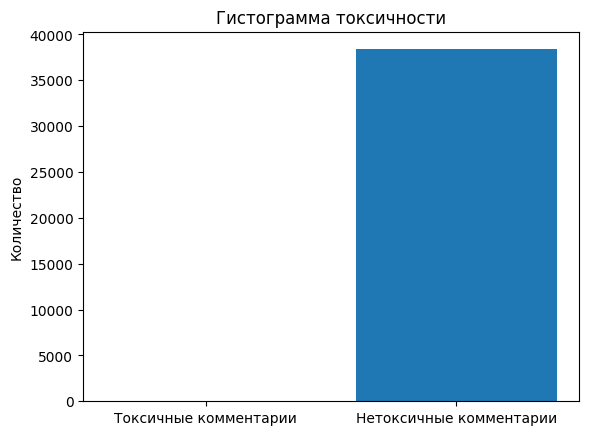

In [ ]:
#print(df['id'].count())
#display(df[df['toxicity'] > 0]['id'].count())
#display(df[df['toxicity'] == 0]['id'].count())
# Считаем количество строк
df['toxicity'] = df['toxicity'].astype(int)
counts = {
    'Токсичные комментарии': df[df['toxicity'] > 0]['id'].count(),
    'Нетоксичные комментарии': df[df['toxicity'] == 0]['id'].count(),
}

# Строим гистограмму
plt.bar(counts.keys(), counts.values())
plt.ylabel('Количество')
plt.title('Гистограмма токсичности')
plt.show()

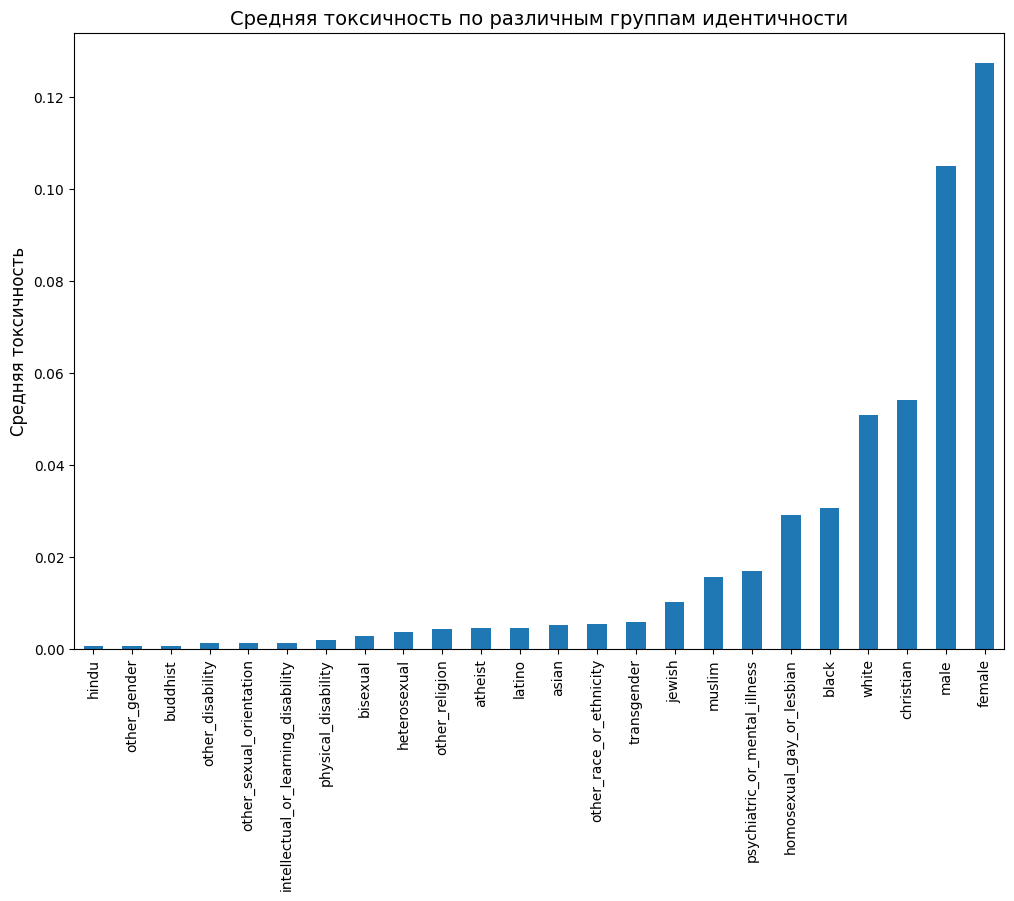

In [ ]:
# Смотрим среднюю токсичность по меткам
identity_columns = [
    'asian', 'atheist', 'bisexual', 'black', 'buddhist', 'christian', 'female', 'heterosexual',
    'hindu', 'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability', 'jewish',
    'latino', 'male', 'muslim', 'other_disability', 'other_gender', 'other_race_or_ethnicity',
    'other_religion', 'other_sexual_orientation', 'physical_disability', 'psychiatric_or_mental_illness',
    'transgender', 'white'
]

plt.figure(figsize=(12, 8))
df[identity_columns].mean().sort_values().plot(kind='bar')
plt.title('Средняя токсичность по различным группам идентичности', fontsize=14)
plt.ylabel('Средняя токсичность', fontsize=12)

plt.show()

Зависимость длины комментария и его токсичность(корелляция)

Зависимость длины комментария и какого то признака идентификации(корелляция)

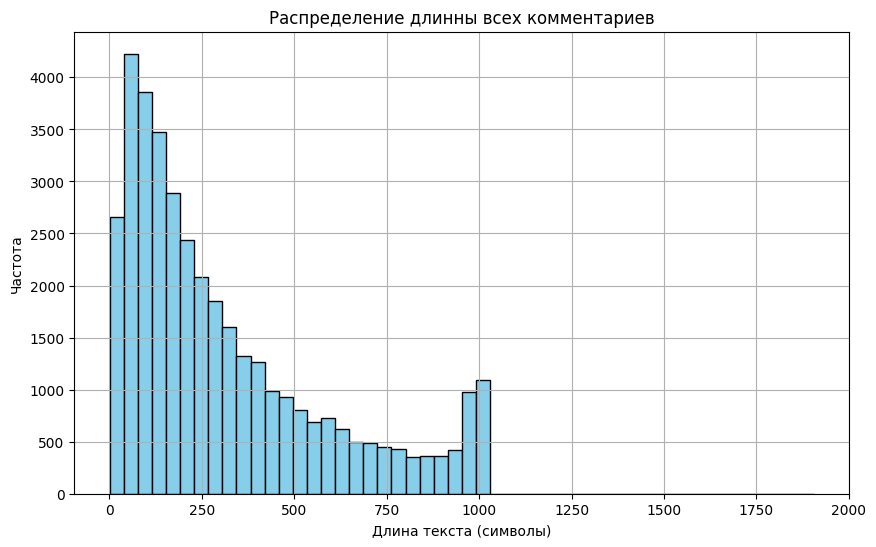

'Средняя длина комментария: 315'

'Медианная длина комментария: 220.0'

'Минимальная длина комментария: 1'

'Максимальная длина комментария: 1906'

In [ ]:
# Функций создающая графики
df['comm_length'] = df['comment_text'].fillna("").apply(len)

def format_val(val):
  return "{:.0f}".format(val)

def hist_len(data, title):
    median_length = data['comm_length'].median()
    mean_length = data['comm_length'].mean()
    min_length = data['comm_length'].min()
    max_length = data['comm_length'].max()

    plt.figure(figsize=(10, 6))
    plt.hist(data['comm_length'], bins=50, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel('Длина текста (символы)')
    plt.ylabel('Частота')
    plt.grid(True)
    plt.show()

    display(f'Средняя длина комментария: {format_val(mean_length)}')
    display(f'Медианная длина комментария: {median_length}')
    display(f'Минимальная длина комментария: {min_length}')
    display(f'Максимальная длина комментария: {max_length}')

hist_len(df, 'Распределение длинны всех комментариев')

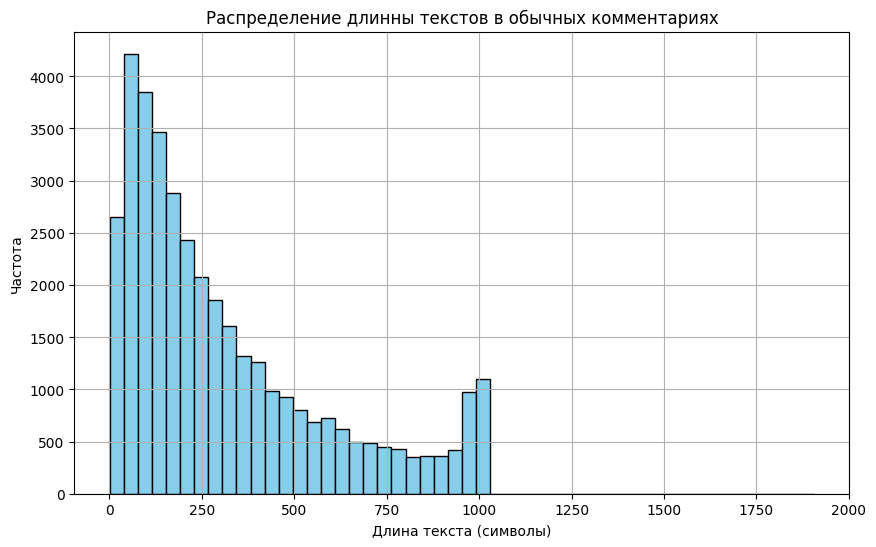

'Средняя длина комментария: 315'

'Медианная длина комментария: 220.0'

'Минимальная длина комментария: 1'

'Максимальная длина комментария: 1906'

In [ ]:
hist_len(df[df.toxicity == 0], 'Распределение длинны текстов в обычных комментариях')

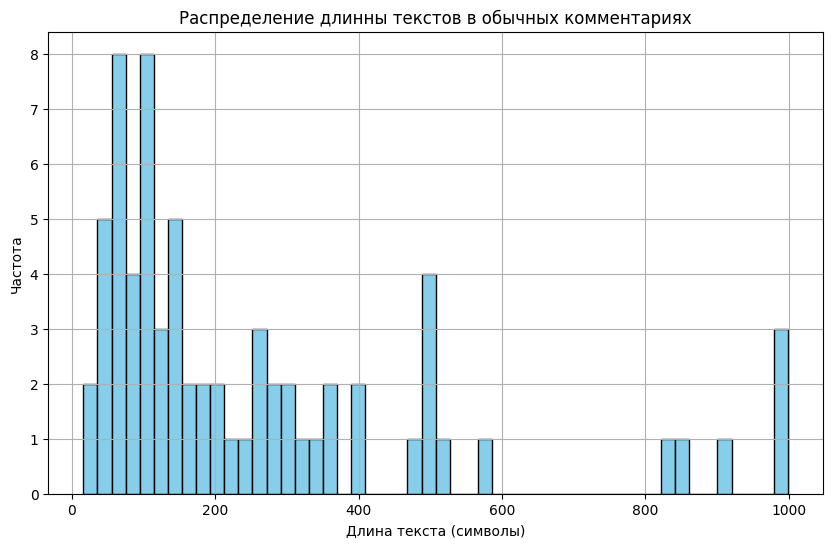

'Средняя длина комментария: 258'

'Медианная длина комментария: 153.0'

'Минимальная длина комментария: 16'

'Максимальная длина комментария: 999'

In [ ]:
hist_len(df[df.toxicity > 0], 'Распределение длинны текстов в обычных комментариях')

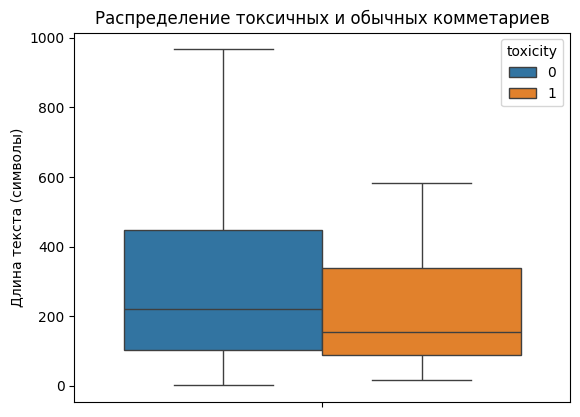

In [ ]:
sns.boxplot(data=df, y = 'comm_length', hue = 'toxicity', showfliers=False)
plt.title('Распределение токсичных и обычных комметариев')
plt.ylabel('Длина текста (символы)')
plt.show()

Выявить корелляцию между лайками и токсичностью комментариев(Видим что корелляция не сильная)

<Axes: >

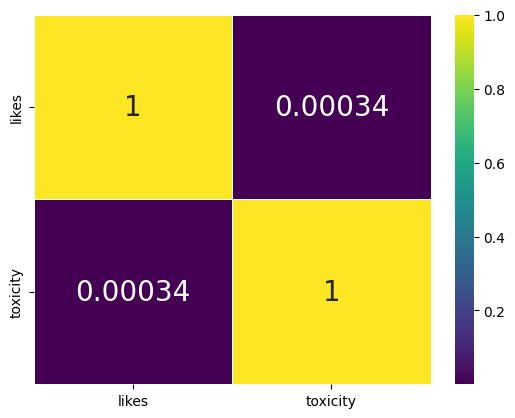

In [ ]:
sns.heatmap(df[['likes', 'toxicity']].corr(numeric_only=True),
            linewidth=0.5, annot=True, cmap='viridis',
            linecolor='white', annot_kws={'size': 20})

## Анализ реакций с разделением на токсичные и обычные комментарии

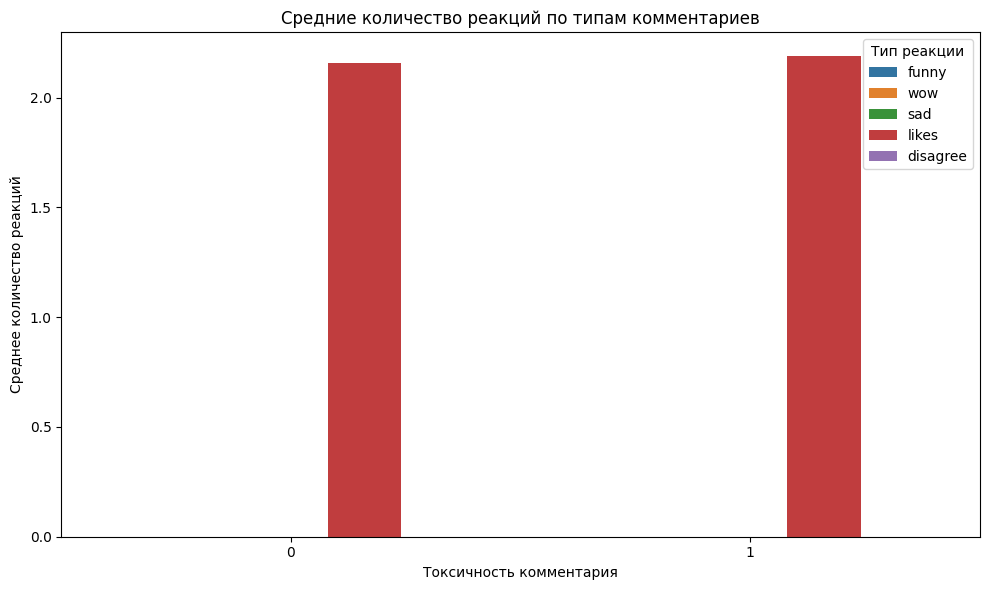

In [ ]:
res = df.groupby('toxicity')[['funny','wow','sad','likes','disagree']].mean().reset_index()
res = res.melt(
    id_vars='toxicity',
    value_vars = ['funny','wow','sad','likes','disagree'],
    var_name = 'Тип реакции',
    value_name = 'Среднее значение'
)
plt.figure(figsize=(10, 6))
sns.barplot(data=res, x='toxicity', y='Среднее значение', hue='Тип реакции')

plt.title('Средние количество реакций по типам комментариев')
plt.xlabel('Токсичность комментария')
plt.ylabel('Среднее количество реакций')

# Показать график
plt.tight_layout()
plt.show()


Анализ подтипов токсичности


In [ ]:
atc = ['severe_toxicity','obscene',
       'identity_attack','insult','threat',
       'sexual_explicit']
df[df.toxicity > 0][atc].median().sort_values().to_frame()

,0
severe_toxicity,0.0
obscene,0.0
identity_attack,0.0
threat,0.0
sexual_explicit,0.0
insult,1.0


NLP - Работа с текстом

In [ ]:
def remove_extra_symbols(text):
    """
    Удаляет лишние символы из текста, включая ссылки.

    :param text: Строка текста для очистки.
    :return: Очищенный текст.
    """

    text = re.sub(r'(https?://\S+|www\.\S+)', '', text)

    # Удаление лишних символов
    cleaned_text = re.sub(r'[^a-zA-Zа-яА-Я0-9\s]', ' ', text)

    # Удаление лишних пробелов
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text

def get_wordnet_pos(treebank_tag):
    """
    Функция проверяет, какой тег части речи передан в параметр
    для преобразования POS-тегов

    :param text: Строка текста для очистки.
    :return: Очищенный текст.
    """
    # это прилагательное
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
     # это глагол
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
     # это существительное
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
      # это наречие
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

#Стоп-слова — это слова, которые часто встречаются практически в любом
#тексте и ничего интересного не говорят о конретном документе,
#то есть играют роль шума. Поэтому их принято убирать.
#По той же причине убирают и пунктуацию.

stop_words = set(stopwords.words('english'))
#display(stop_words)

lemmatizer = WordNetLemmatizer()

# Обработка текста и преобразование в токены
def preprocess_text(text):
    # Токенизация
    tokens = nltk.word_tokenize(remove_extra_symbols(text.lower()))
    tokens = [word for word in tokens if word not in stop_words]
    # Применение POS-теггинга
    pos_tags = pos_tag(tokens)

    # Лемматизация с учётом POS-тегов
    tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(pos)) for token, pos in pos_tags]

    return tokens

# Возвращение текста из состояние токенов в состояние обычной строки

def tts(token):
    return ' '.join(token)

def pos_tagging(tokens):
    return nltk.pos_tag(tokens, tagset='universal')

Делаем саму токенизацию

In [ ]:
start = time.time()
df['tokens'] = df.comment_text.fillna("").apply(preprocess_text)
end = time.time()
print((end - start)/60, "Время которое потребовалось на токенизацию")

2.2154634674390157 Время которое потребовалось на токенизацию


Берем первым 10 токенов?

In [ ]:
df.tokens[:10].apply(tts)[0]

'fuck civil comment horseshit enough censorship communist fuckwits adn adn fucking choke'

In [ ]:
all_words = [word for tokens in df['tokens'] for word in tokens]
bigrams = [ngram for tokens in df['tokens'] for ngram in ngrams(tokens, 2)]
trigrams = [ngram for tokens in df['tokens'] for ngram in ngrams(tokens, 3)]
awt = [word for tokens in df[df.toxicity > 0]['tokens'] for word in tokens]
bt = [ngram for tokens in df[df.toxicity > 0]['tokens'] for ngram in ngrams(tokens, 2)]
tt = [ngram for tokens in df[df.toxicity > 0]['tokens'] for ngram in ngrams(tokens, 3)]

In [ ]:
# функция для построения гистограммы
def histpltc(d, title, xl, yl, t='w'):
    if t == 'w':
        data = dict(d)
        plt.figure(figsize=(8, 10))
        sns.barplot(y=list(data.keys()), x=list(data.values()))
        plt.xlabel(xl)
        plt.ylabel(yl)
        plt.title(title)
        plt.xticks(rotation=60)
        plt.show()
    else:
        labels = [' '.join(pair) for pair, count in d]
        counts = [count for pair, count in d]
        plt.figure(figsize=(8, 10))
        sns.barplot(y=labels, x=counts)
        plt.xlabel(xl)
        plt.ylabel(yl)
        plt.title(title)
        plt.xticks(rotation=60)
        plt.show()

In [ ]:
word_freq = Counter(all_words).most_common(30)
word_freq_t = Counter(awt).most_common(30)
bigram_freq = Counter(bigrams).most_common(30)
bigram_freq_t = Counter(bt).most_common(30)
trigram_freq = Counter(trigrams).most_common(30)
trigram_freq_t = Counter(tt).most_common(30)

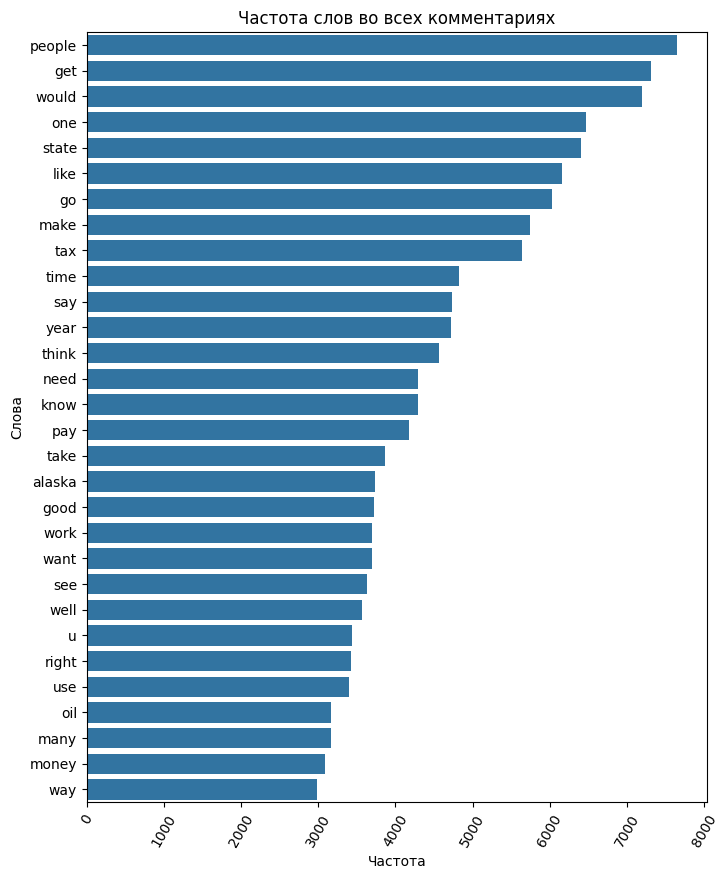

In [ ]:
histpltc(word_freq, 'Частота слов во всех комментариях', 'Частота', 'Слова')

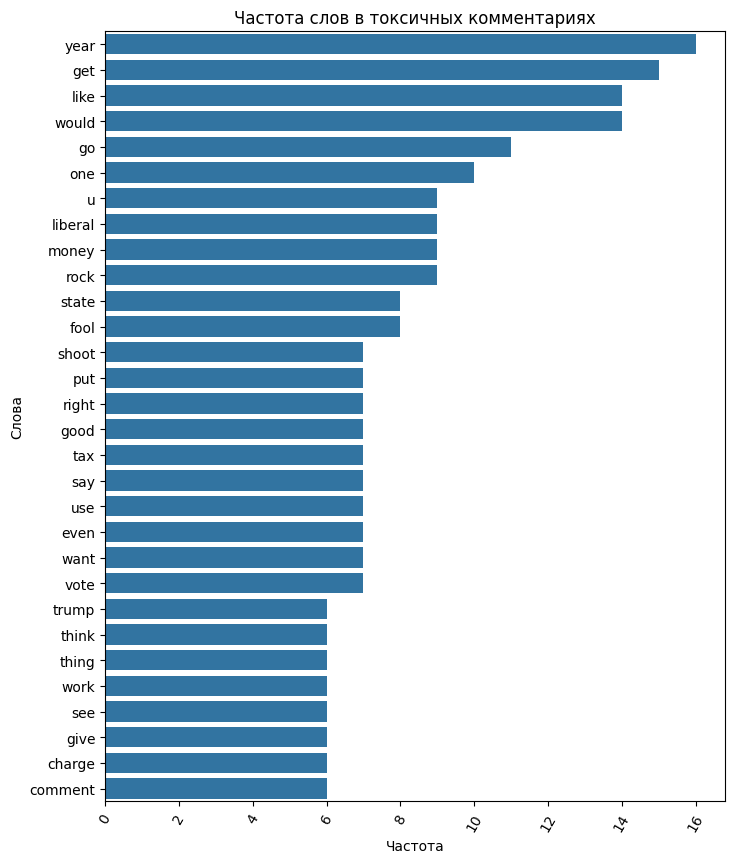

In [ ]:
histpltc(word_freq_t, 'Частота слов в токсичных комментариях', 'Частота', 'Слова')

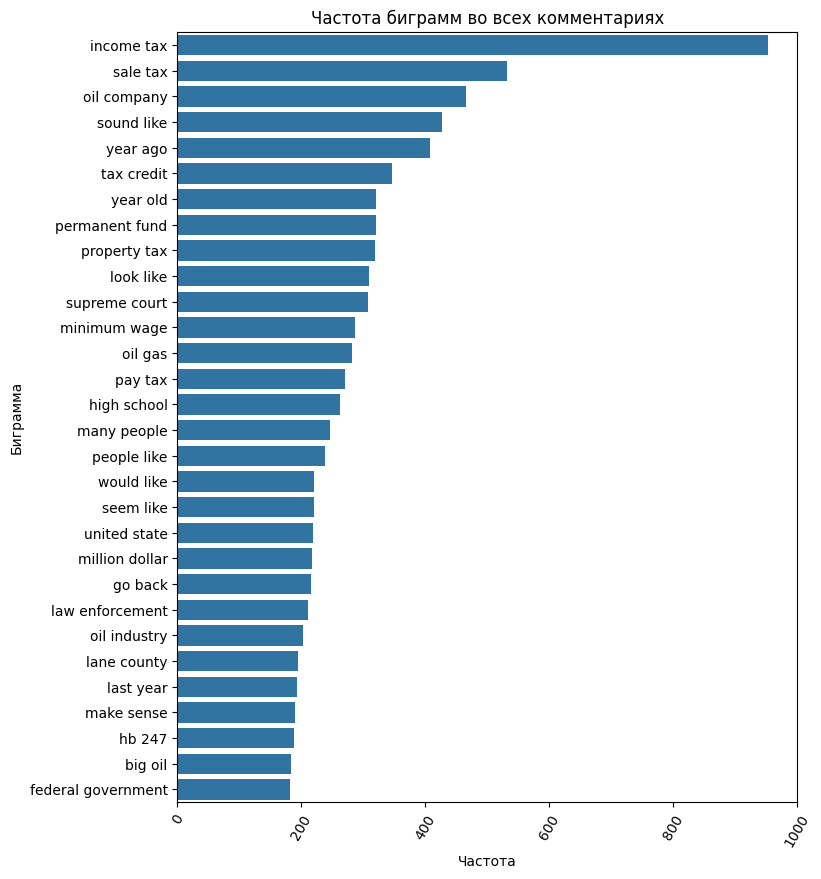

In [ ]:
histpltc(bigram_freq, 'Частота биграмм во всех комментариях', 'Частота', 'Биграмма',t='t')

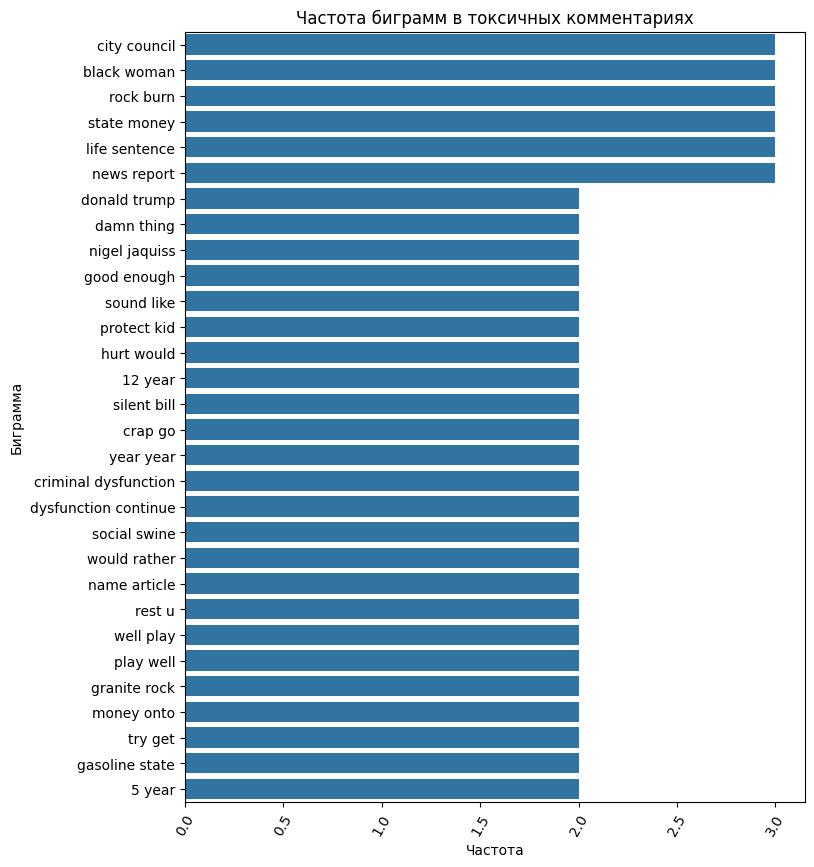

In [ ]:
histpltc(bigram_freq_t, 'Частота биграмм в токсичных комментариях', 'Частота', 'Биграмма',t='t')


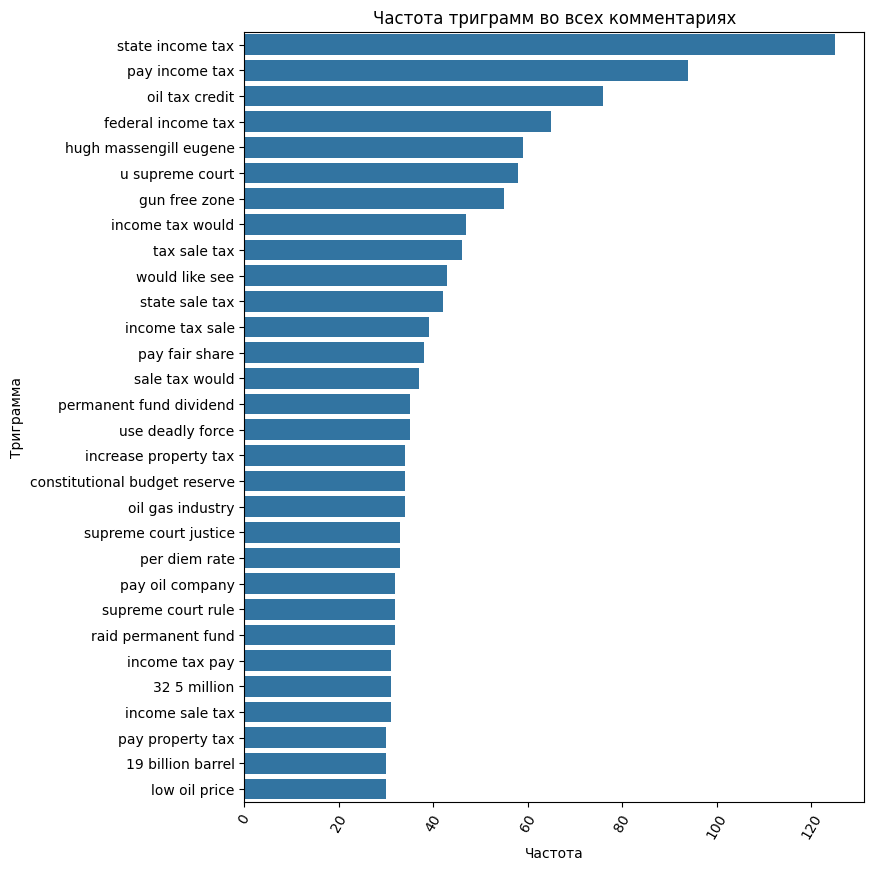

In [ ]:
histpltc(trigram_freq, 'Частота триграмм во всех комментариях', 'Частота', 'Триграмма',t='t')

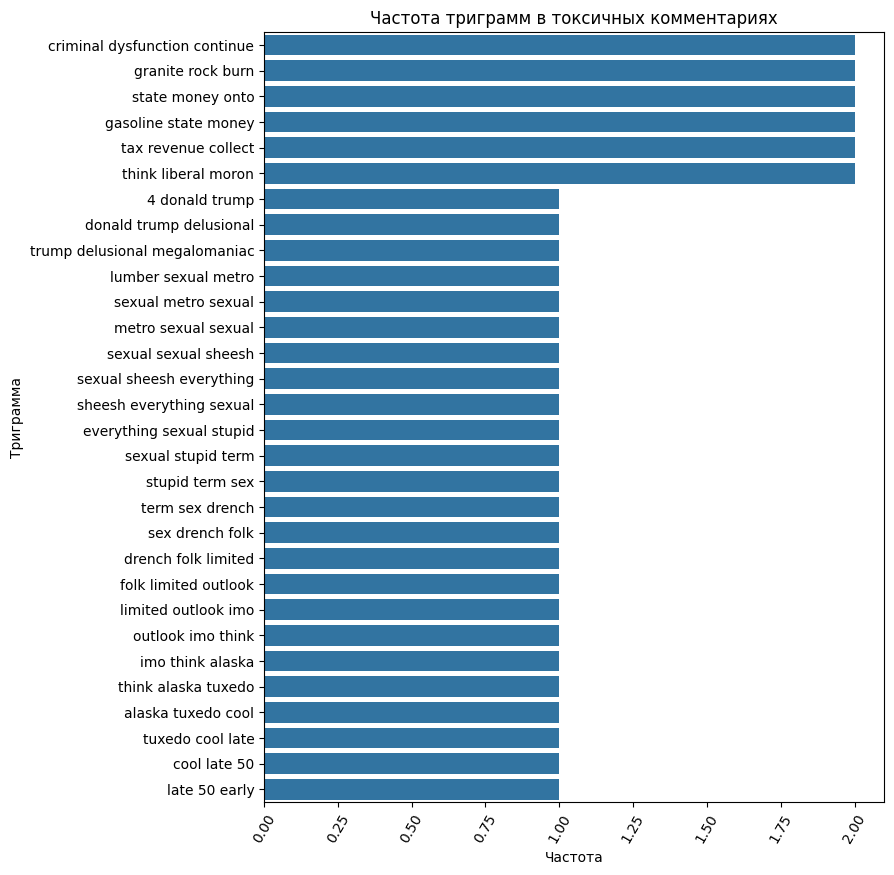

In [ ]:
histpltc(trigram_freq_t, 'Частота триграмм в токсичных комментариях', 'Частота', 'Триграмма',t='t')

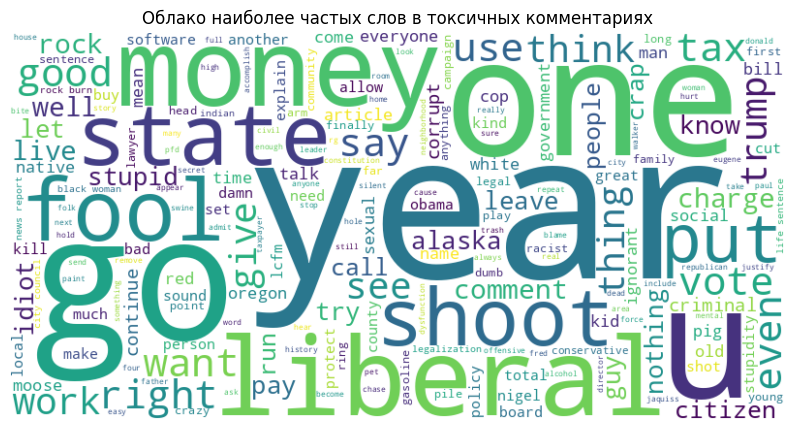

In [ ]:
from wordcloud import WordCloud
awt_str = ' '.join(awt)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(awt_str)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако наиболее частых слов в токсичных комментариях')
plt.show()

In [ ]:
start = time.time()

sample_texts = df['tokens'].apply(pos_tagging)
all_sample_pos_tags = [tag for tags in sample_texts for _, tag in tags]

end = time.time()
print((end - start)/60, "Сколько занимает времени получение частей речи из токенов, минут")

1.8357858419418336 Сколько занимает времени получение частей речи из токенов


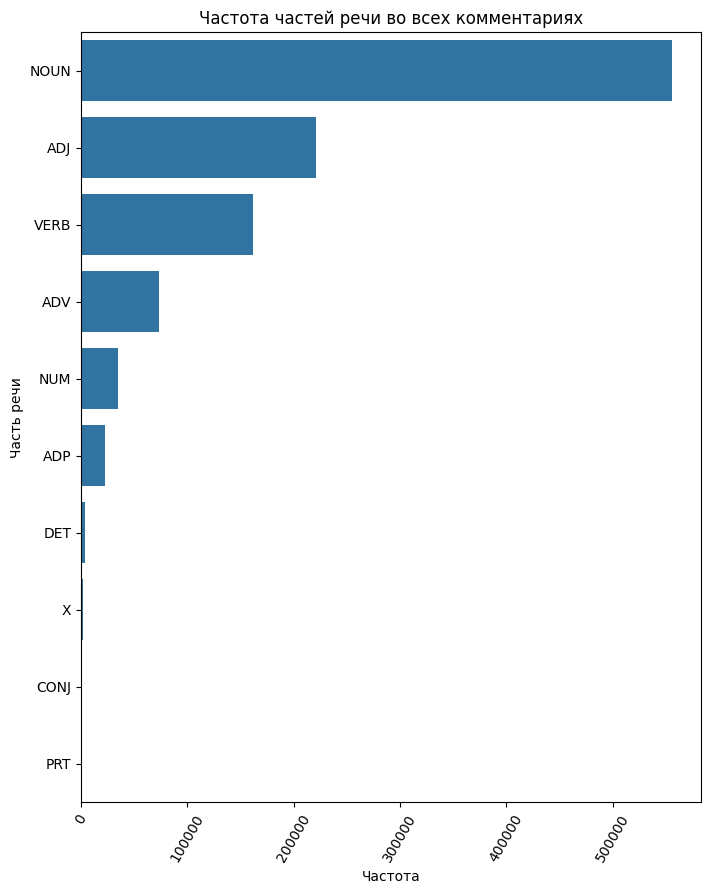

In [ ]:
pos_freq_sample = Counter(all_sample_pos_tags).most_common(10)
histpltc(pos_freq_sample, 'Частота частей речи во всех комментариях', 'Частота', 'Часть речи')

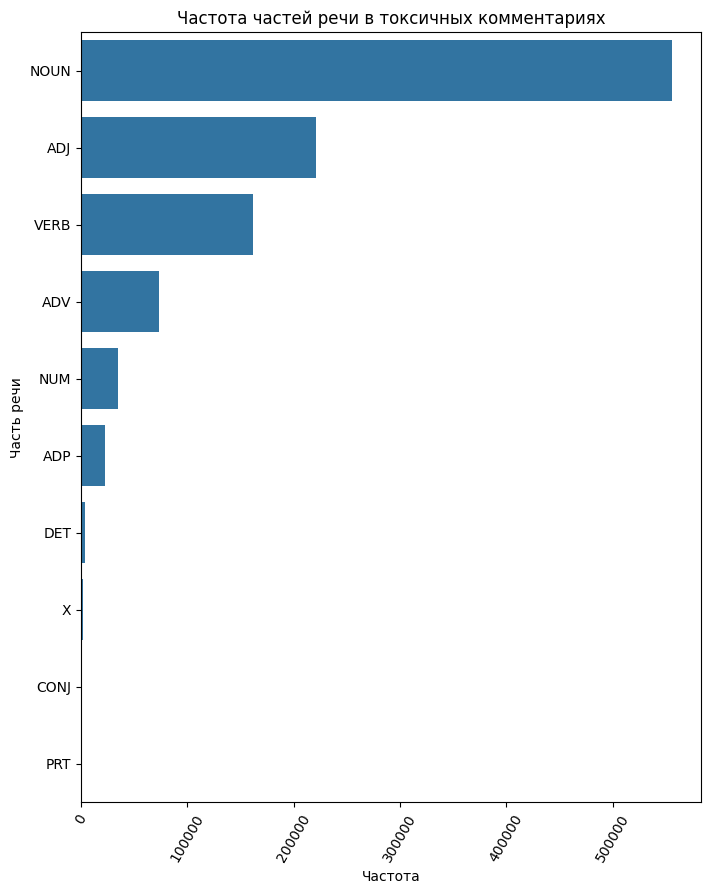

In [ ]:
stt = sample_texts[df.toxicity > 0]
all_sample_pos_tags_t = [tag for tags in stt for _, tag in tags]
pos_freq_sample_t = Counter(all_sample_pos_tags_t).most_common(10)
histpltc(pos_freq_sample, 'Частота частей речи в токсичных комментариях', 'Частота', 'Часть речи')